In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('Online retail.csv',header=None)  
df.columns = ['Items']

In [3]:
df.head()

,Items
0,"shrimp,almonds,avocado,vegetables mix,green gr..."
1,"burgers,meatballs,eggs"
2,chutney
3,"turkey,avocado"
4,"mineral water,milk,energy bar,whole wheat rice..."


# **Data Preprocessing**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7501 entries, 0 to 7500
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Items   7501 non-null   object
dtypes: object(1)
memory usage: 58.7+ KB


In [5]:
df.isnull().sum()

Items    0
dtype: int64

In [6]:
# Convert the dataset into a list of transactions (splitting by comma)
transactions = df.iloc[:, 0].apply(lambda x: x.split(','))

# Display the first few transactions to verify the transformation
transactions.head()


0    [shrimp, almonds, avocado, vegetables mix, gre...
1                           [burgers, meatballs, eggs]
2                                            [chutney]
3                                    [turkey, avocado]
4    [mineral water, milk, energy bar, whole wheat ...
Name: Items, dtype: object

# **Association Rule Mining**

In [7]:
!pip install -U mlxtend

  Using cached mlxtend-0.23.2-py3-none-any.whl (1.4 MB)
  Using cached scikit_learn-1.5.2-cp39-cp39-win_amd64.whl (11.0 MB)
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [8]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [9]:
# Convert transactions into a one-hot encoded DataFrame
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

In [10]:
# Set minimum support threshold (e.g., 0.01 for 1%)
min_support = 0.01

In [11]:
# Generate frequent itemsets with minimum support
frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)

In [12]:
frequent_itemsets.head()

,support,itemsets
0,0.020397,(almonds)
1,0.033329,(avocado)
2,0.010799,(barbecue sauce)
3,0.014265,(black tea)
4,0.011465,(body spray)


In [13]:
min_confidence = 0.2
min_lift = 1.2

In [14]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence,num_itemsets=len(frequent_itemsets))


In [15]:
rules = rules[rules['lift'] >= min_lift]

# Display the generated rules
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()

,antecedents,consequents,support,confidence,lift
0,(avocado),(mineral water),0.011598,0.348000,1.459926
1,(burgers),(eggs),0.028796,0.330275,1.837830
2,(burgers),(french fries),0.021997,0.252294,1.476173
3,(burgers),(green tea),0.017464,0.200306,1.516139
4,(burgers),(milk),0.017864,0.204893,1.581175


# **Analysis and Interpretation**

In [16]:
# Sort rules by lift in descending order
sorted_rules = rules.sort_values(by='lift', ascending=False)
sorted_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()

,antecedents,consequents,support,confidence,lift
75,(herb & pepper),(ground beef),0.015998,0.323450,3.291994
153,"(spaghetti, mineral water)",(ground beef),0.017064,0.285714,2.907928
69,(tomatoes),(frozen vegetables),0.016131,0.235867,2.474464
67,(shrimp),(frozen vegetables),0.016664,0.233209,2.446574
145,"(milk, mineral water)",(frozen vegetables),0.011065,0.230556,2.418737


Looking at the top 5 association rules sorted by lift, here are some interesting patterns and relationships :

# 1.(Herb & Pepper) → (Ground Beef):

Support: 0.016 (1.6% of transactions)

Confidence: 0.32 (32.3% of transactions that include herb & pepper also include ground beef)

Lift: 3.29 (This rule suggests that ground beef is 3.29 times more likely to be purchased when herb & pepper is bought in a transaction compared to random occurrence).

Insight: Customers who buy herb & pepper are likely preparing meals that involve ground beef, indicating a culinary pairing. Marketing campaigns could promote ground beef as a complementary product when customers purchase herb & pepper.

# 2.(Mineral Water, Spaghetti) → (Ground Beef):

Support: 0.017 (1.7% of transactions)

Confidence: 0.29 (28.6% chance that if mineral water and spaghetti are purchased together, ground beef will also be bought)

Lift: 2.91

Insight: This suggests that mineral water, spaghetti, and ground beef are frequently bought together, possibly for a pasta-related meal. Promotions or discounts on pasta ingredients when mineral water is purchased could encourage additional sales.

# 3.(Tomatoes) → (Frozen Vegetables):

Support: 0.016 (1.6% of transactions)

Confidence: 0.24 (23.6% chance that if tomatoes are bought, frozen vegetables are also bought)

Lift: 2.47

Insight: Customers buying tomatoes often buy frozen vegetables as well. This could indicate a focus on health-conscious meal preparation. Supermarkets could place frozen vegetables near fresh produce to encourage this purchase combination.

# 4.(Shrimp) → (Frozen Vegetables):

Support: 0.017 (1.7% of transactions)

Confidence: 0.23 (23.3% of shrimp-buying transactions also include frozen vegetables)

Lift: 2.45

Insight: Shrimp and frozen vegetables are frequently bought together, likely for convenient meal preparation. Bundling seafood with frozen vegetables could appeal to customers looking for quick, healthy meal options.

# 5.(Mineral Water, Milk) → (Frozen Vegetables):

Support: 0.011 (1.1% of transactions)

Confidence: 0.23

Lift: 2.42

Insight: Milk, mineral water, and frozen vegetables may reflect a specific segment of customers who are health-focused or family-oriented. Placing these items in close proximity might increase cross-selling.

# **Visualizing Association rules using a scatter plot**

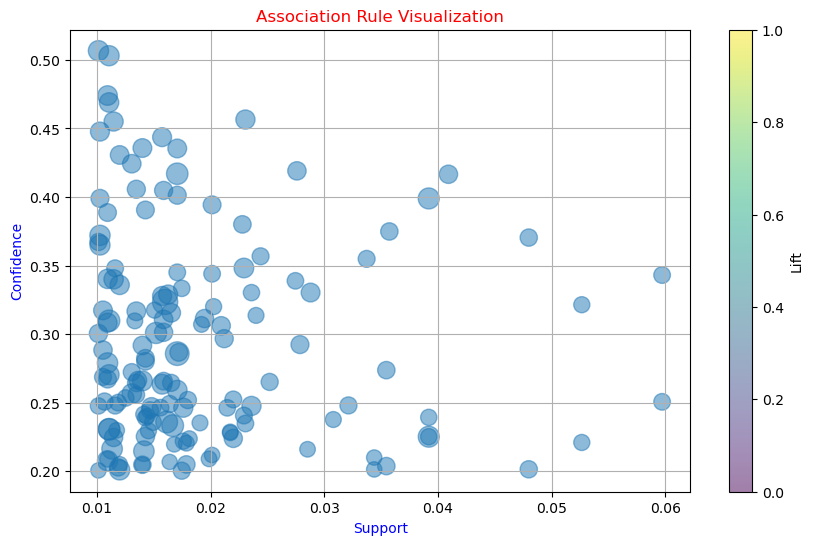

In [17]:
import matplotlib.pyplot as plt

# Assuming 'rules' is your DataFrame containing association rules
plt.figure(figsize=(10, 6))
plt.scatter(rules['support'], rules['confidence'], s=rules['lift']*100, alpha=0.5)
plt.xlabel('Support',color='blue')
plt.ylabel('Confidence',color='blue')
plt.title('Association Rule Visualization',color='red')
plt.colorbar(label='Lift')
plt.grid(True)
plt.show()

# Interview Questions:


1.What is lift and why is it important in Association rules?

Ans:Lift is a measure used in association rule mining to evaluate the strength of an association rule compared to the expected likelihood of the items being associated if they were independent. In simpler terms, lift tells you how much more likely the items in the rule are to occur together than would be expected by chance.

2.What is support and Confidence. How do you calculate them?

a.Support
Support measures how frequently an itemset appears in the dataset. It helps to identify how common or rare an itemset is.
Support of an itemset A is defined as the proportion of transactions in the dataset that contain the itemset A

b.Confidence measures the likelihood that itemset 
B is purchased when itemset 𝐴 is purchased. It evaluates the reliability of the rule A→𝐵

